# COVID-19 Live Forecasting
> Tracking coronavirus total cases, deaths and new cases by countries.

In [0]:
import numpy as np
import pandas as pd
from jinja2 import Template
from IPython.display import HTML

In [17]:
!pip install squarify

In [18]:
!pip install plotly_express

In [0]:
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:


# FETCH
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': base_url + 'mapping_countries.csv',
    'overview': base_url + 'overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url)
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }

mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [0]:

COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]


dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()

In [22]:

df_table = (pd.DataFrame(dict(Cases=dfc_cases, Deaths=dfc_deaths, PCases=dfp_cases, PDeaths=dfp_deaths))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.head(20)

,Country/Region,Cases,Deaths,PCases,PDeaths,Cases (+),Deaths (+),Fatality Rate,Continent
0,US,2023347,113820,1925765,110068,97582,3752,5.6,North America
1,Brazil,802828,40919,672846,35930,129982,4989,5.1,South America
2,Russia,501800,6522,458102,5717,43698,805,1.3,Europe
3,India,297535,8498,246622,6946,50913,1552,2.9,Asia
4,United Kingdom,292860,41364,286294,40548,6566,816,14.1,Europe
5,Spain,242707,27136,241310,27135,1397,1,11.2,Europe
6,Italy,236142,34167,234801,33846,1341,321,14.5,Europe
7,Peru,214788,6088,191758,5301,23030,787,2.8,South America
8,France,192493,29349,190759,29145,1734,204,15.2,Europe
9,Germany,186691,8772,185450,8673,1241,99,4.7,Europe


In [0]:

#delete problematic countries from table
df_table = df_table[~df_table['Country/Region'].isin(['Cape Verde', 'Cruise Ship', 'Kosovo'])]

In [24]:

# world, china, europe, us
metrics = ['Cases', 'Deaths', 'Cases (+)', 'Deaths (+)']
s_china = df_table[df_table['Country/Region'].eq('China')][metrics].sum().add_prefix('China ')
s_us = df_table[df_table['Country/Region'].eq('US')][metrics].sum().add_prefix('US ')
s_eu = df_table[df_table['Continent'].eq('Europe')][metrics].sum().add_prefix('EU ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_5ago)}
summary = {**summary, **df_table[metrics].sum(), **s_china, **s_us, **s_eu}
summary

{'Cases': 7513155,
 'Cases (+)': 612420,
 'China Cases': 84216,
 'China Cases (+)': 30,
 'China Deaths': 4638,
 'China Deaths (+)': 0,
 'Deaths': 421427,
 'Deaths (+)': 21406,
 'EU Cases': 2146164,
 'EU Cases (+)': 77386,
 'EU Deaths': 181405,
 'EU Deaths (+)': 2892,
 'US Cases': 2023347,
 'US Cases (+)': 97582,
 'US Deaths': 113820,
 'US Deaths (+)': 3752,
 'since': Timestamp('2020-06-06 00:00:00'),
 'updated': Timestamp('2020-06-11 00:00:00')}

Time Series Forecasting for the perticular dates

In [25]:

dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.head(28)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,235,190,330,168,171,215,255,369,285,276,263,413,414,349,262,408,581,492,531,540,782,584,591,658,625,580,623,866,680,545,759,758,787,915,582,791,575,542,683,748
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,8,17,12,10,8,6,12,4,4,4,18,18,17,13,2,1,15,5,12,8,9,6,25,21,26,23,23,15,6,21,20,13,15,20,14,17,36,42,44
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,179,174,190,159,185,187,189,165,168,176,186,189,187,192,198,182,176,165,186,190,195,193,197,194,160,140,137,133,127,119,113,107,98,104,115,104,111,117,102,105
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,1,0,2,1,0,3,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,79,7,1,0,0,0,0,0,0,0
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,7,0,2,0,0,0,3,0,0,0,2,2,0,6,2,1,8,1,0,1,3,7,3,2,0,0,0,0,0,2,3,1,4,17,5
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,102,104,133,188,163,240,165,258,244,285,316,255,345,326,263,303,438,474,648,718,704,723,552,600,705,769,717,795,637,564,904,949,929,840,983,774,826,1141,1226,1386
Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,113,121,112,163,102,145,146,138,79,146,180,142,184,239,189,351,218,230,335,322,374,359,452,289,372,442,460,251,355,210,517,515,697,596,547,766,195,350,428,566
Australia,0,0,0,0,4,1,0,1,3,0,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2,...,23,25,28,19,19,5,21,9,22,10,9,30,16,9,10,14,4,9,14,4,15,0,12,13,11,15,19,8,10,19,8,11,7,5,7,6,2,7,11,4


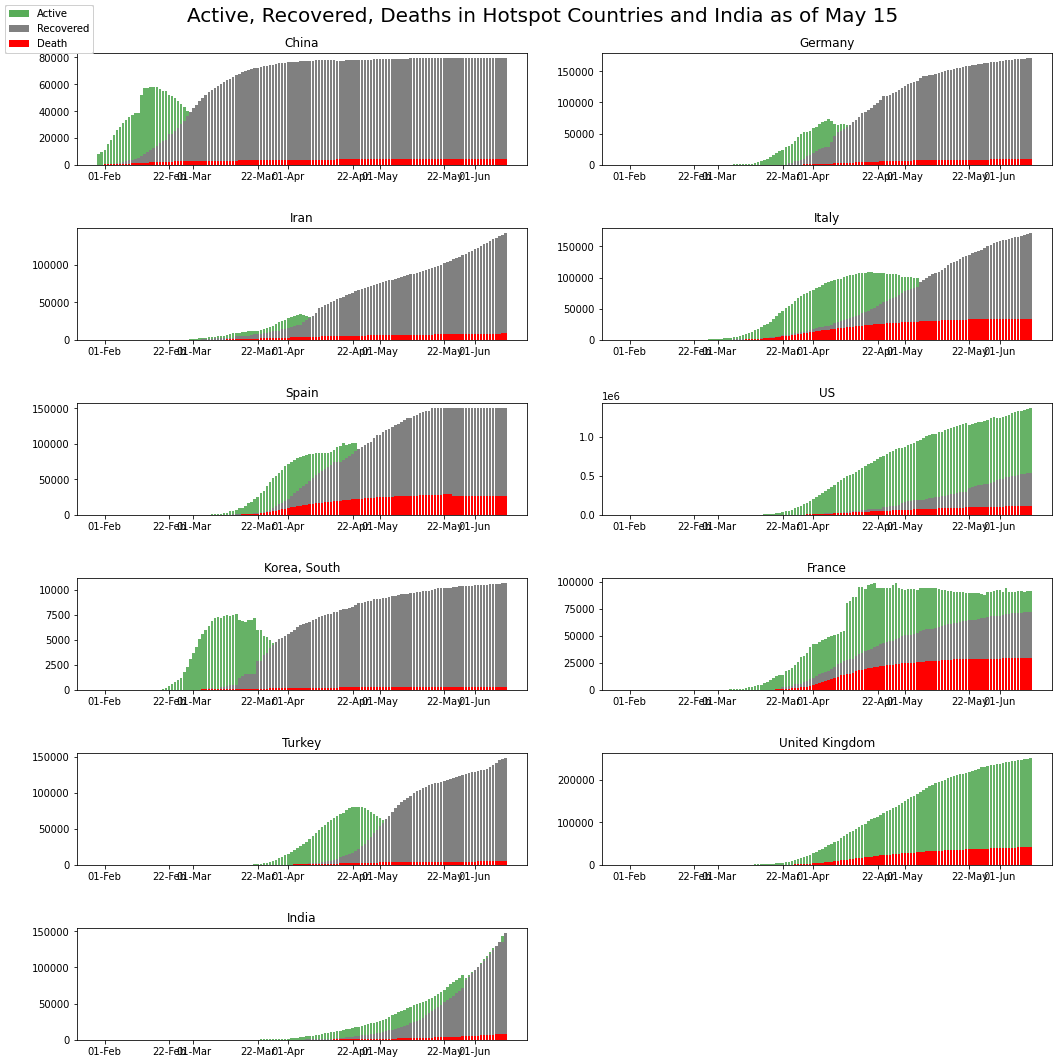

In [80]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of May 15',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)

____

## Forcasting Plot in Latest dates 

* this plot shows the new real time caes statistics in the following countries.
* As we see India stands at 5th position with with 2,97,583 cases.

In [26]:

template = Template(get_template(paths['overview']))
html = template.render(
    D=summary, table=df_table,  # REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[LAST_DATE_I-50]:dt_cols[LAST_DATE_I]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

___

## India Covid-19 Pandemic

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [0]:
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [0]:
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [0]:
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

india_covid_19 = pd.read_csv('covid_19_india.csv')
state_testing = pd.read_csv('StatewiseTestingDetails.csv')
population = pd.read_csv('population_india_census2011.csv')
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])

In [0]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

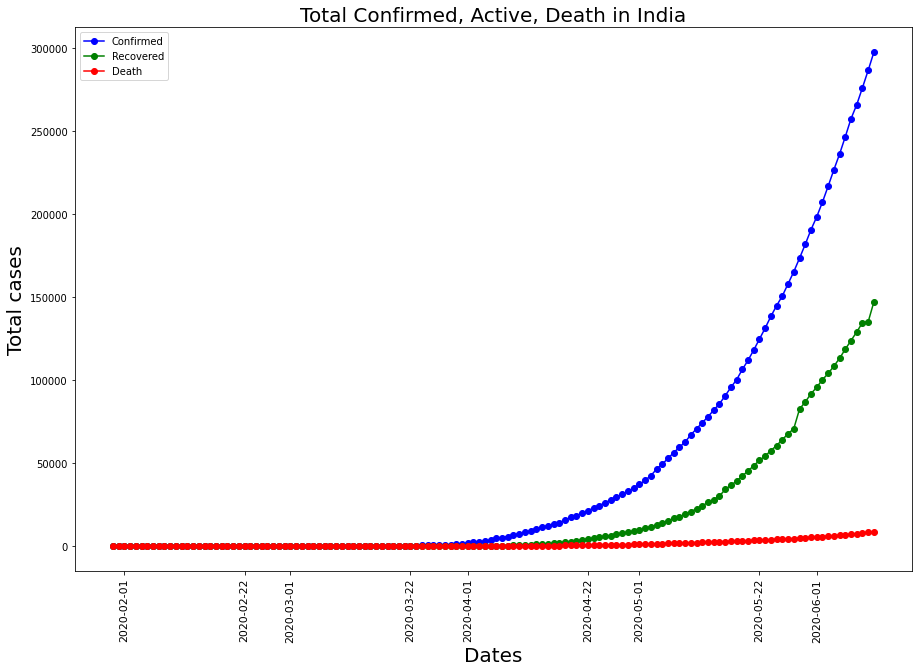

In [35]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

##Prediction In India
___

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

Avg Growth Rate

In [81]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'6/10/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.0381361106749707


prediction in next 15 days

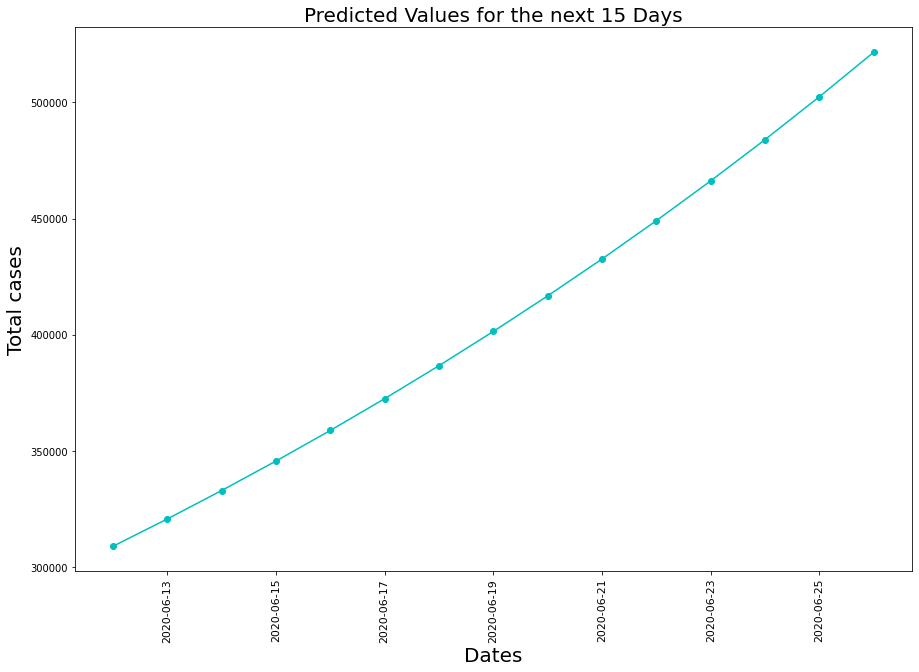

In [92]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed['India'][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')